集成广义线性贝叶斯，效果优于传统广义线性BN方法
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from theano import shared
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from DataSplit import *
from PCA import *
from RMSE import *

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.style.use('default')
font1 ={'family': 'times new roman', 'weight':'light', 'size': 12}  
# font2 ={'family': 'Arial', 'weight':'normal', 'size': 12}  
def Plot_XZ(elec_year, elec_faults, Savefig):
# 画出原始图
    Company_names = ['Xizang', 'Xinjiang', 'Heilongjiang']
    k = np.array([0, 41, 83])
    j= 0
    # j, k1 = 0, 6
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi1.png', dpi = 200, bbox_inches='tight')
    plt.show()
    plt.figure(figsize=(4, 3), facecolor='w')

    ax = plt.subplot(1, 1, 1)
    for jx in range(7, 14, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[1]], loc='upper left', frameon=False, fontsize='small')
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi2.png', dpi = 200, bbox_inches='tight')
    plt.show()
    
    plt.figure(figsize=(4, 3), facecolor='w')
    ax = plt.subplot(1, 1, 1)
    for jx in range(14, 21, 1):
        ax.plot(elec_year[jx], elec_faults[jx], 'ko--', markersize=4, linewidth=1)
        # j = j+k1
    ax.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'], fontsize='small')
    ax.set_xlabel("time(year)", fontdict=font1)
    plt.ylabel("Failure rate(%)", fontdict=font1)
    plt.legend([Company_names[2]], loc='upper left', frameon=False, fontsize='small')
#     leg = plt.legend()
#     leg.get_frame().set_linewidth(0.0)
    
#     plt.grid()
    if Savefig == 1:
        plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Yuanshi3.png', dpi = 200, bbox_inches='tight')
    plt.show()
    return 0

(126, 4)


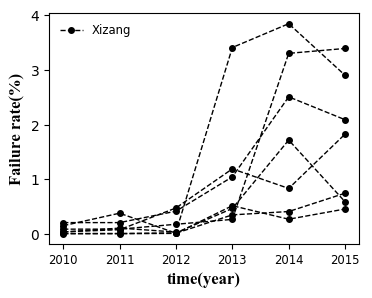

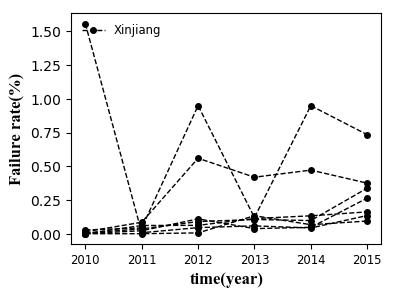

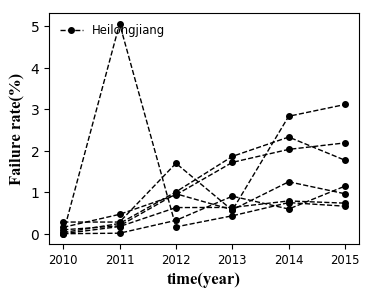

In [3]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储

elec_data = pd.read_csv('XZmulti_6.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# companys = elec_data.counts.values - 1 # 这一句以上面两行功能相同
# elec_count = elec_data.counts.values

# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 2, size=[len(elec_data.Year.values), 4])
SNR_Tem = np.random.normal(0, 1, size=[len(elec_data.Year.values), 1])
# #特征因素分析

elec_tem = elec_data.Tem.values + SNR_Tem[:, 0] # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 1]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 2] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 3] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)


# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
data_cs_year = elec_year
elec_year_Mean = (elec_year - np.mean(elec_year)) #均值化后的时间点
# elec_year = elec_year_Mean
# print(elec_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
print(np.shape(elec_Pca))
# np.savetxt('elec_Pca.csv', elec_Pca, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
# elec_Pca_char1 = np.loadtxt('elec_Pca_char1.csv',delimiter = ',')
# elec_Pca_char2 = np.loadtxt('elec_Pca_char2.csv',delimiter = ',')

elec_data.Fault.values[48] =1200
elec_data.Fault.values[85] =700
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 100 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
# elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*6:(i+1)*6] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*6:(i+1)*6] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*6:(i+1)*6] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*6:(i+1)*6] for i in np.arange(21)])

# 共享变量设置
xs_char1 = shared(np.asarray(elec_Pca_char1))
xs_char2 = shared(np.asarray(elec_Pca_char2))

ys_faults = shared(np.asarray(elec_faults))
xs_year = shared(np.asarray(elec_year))
Num_shared = shared(np.asarray(companyABC))
# 画图
Plot_XZ(elec_year2, elec_faults2, Savefig)

def logit(x):
    return 1/(1+np.exp(-x))
def tlogit(x):
    return 1/(1+tt.exp(-x))
def Phi(x):
    # probit transform
    return 0.5 + 0.5 * pm.math.erf(x/pm.math.sqrt(2))

In [4]:
# np.savetxt('elec_Pca_char1.csv', elec_Pca_char1, delimiter = ',')
# np.savetxt('elec_Pca_char2.csv', elec_Pca_char2, delimiter = ',')

Bayesian  子模型1
---

In [5]:
X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
Y = elec_faults
X_train, X_test, Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
print(np.shape(X_train))
# print(Y_train)
X_train_M1_year = elec_year[0:len(X_train)] #防止变为浮点数
X_train_M2_char1 = X_train[:, 1]
X_train_M2_char2 = X_train[:, 2]
X_train_M1_ABC = X_train[:, 3]
X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
M2_companyABC = np.array(X_train_M1_ABC)

Y_train_M1_faults = Y_train


# 共享变量设置
M2_xs_char1 = shared(np.asarray(X_train_M2_char1))
M2_xs_char2 = shared(np.asarray(X_train_M2_char2))

M2_ys_faults = shared(np.asarray(Y_train_M1_faults))
M2_xs_year = shared(np.asarray(X_train_M1_year))
M2_Num_shared = shared(np.asarray(M2_companyABC))
# M2_companyABC = companyABC

print(M2_companyABC)
print(X_train_M1_year)



[ 2  4  7 11 16 18]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1
 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2
 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6]


In [6]:
# # np.savetxt('Y_train_M1_faults.csv', Y_train_M1_faults, delimiter = ',')
# Y_train_M1_faults = np.loadtxt('Y_train_M1_faults.csv',delimiter = ',')
# X_train_M1_char1 = np.loadtxt('X_train_M1_char1.csv',delimiter = ',')
# X_train_M1_char2 = np.loadtxt('X_train_M1_char2.csv',delimiter = ',')

# # 共享变量设置
# M2_xs_char1 = shared(np.asarray(X_train_M1_char1))
# M2_xs_char2 = shared(np.asarray(X_train_M1_char2))
# M2_ys_faults = shared(np.asarray(Y_train_M1_faults))

In [7]:
# 建模，加上含污染模型对比
with pm.Model() as model_2:
    # define priors
    sdsd = 3
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', sdsd)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', sdsd)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', sdsd)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', sdsd)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd = pm.InverseGamma('sd',3, 0.0001)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2) + tt.sqrt(beta4[M2_Num_shared]**2) ) + beta + \
                                             (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                              beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    sigma_p = pm.HalfCauchy('sigma_p', sdsd)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))
    
    zij_ = pm.theanof.tt_rng().uniform(size=M2_companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[M2_Num_shared]))   

    beta_mu = pm.Deterministic('beta_mu', tt.switch(zij, liner, pi_ij))
    
    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

import theano
with model_2:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_2 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

Average Loss = 131.47: 100%|████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 673.61it/s]
Finished [100%]: Average Loss = 131.68
Average Loss = 111.58: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1103.24it/s]
Finished [100%]: Average Loss = 111.76


In [8]:
# chain_2 = trace_2[2000:]
# # varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
# pm.traceplot(chain_2)
# plt.show()

In [9]:
njob = 1
start = trace_2[0]
start['zij'] = start['zij'].astype(int)
stds = approx.bij.rmap(approx.std.eval())
cov = model_2.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_2b:
    # define priors
    sdsd = 3
    alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    mu_4 = pm.Normal('mu_4', mu=0, tau=.001)
    sd_4 = pm.HalfCauchy('sd_4', sdsd)
    mu_3 = pm.Normal('mu_3', mu=0, tau=.001)
    sd_3 = pm.HalfCauchy('sd_3', sdsd)
    mu_2 = pm.Normal('mu_2', mu=0, tau=.001)
    sd_2 = pm.HalfCauchy('sd_2', sdsd)
    mu_1 = pm.Normal('mu_1', mu=0, tau=.001)
    sd_1 = pm.HalfCauchy('sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    beta4 = pm.Normal('beta4', mu_4, sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', mu_3, sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', mu_2, sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', mu_1, sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M2_Num_shared]**2) + tt.sqrt(beta4[M2_Num_shared]**2)) + beta + \
                                             (beta1[M2_Num_shared] * M2_xs_year + beta2[M2_Num_shared] * M2_xs_char1 +\
                                              beta3[M2_Num_shared] * M2_xs_char2 + beta4[M2_Num_shared] * M2_xs_year * M2_xs_year)))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M2_Num_shared.get_value()))

    # latent model for contamination
    sigma_p = pm.HalfCauchy('sigma_p', sdsd)
    mu_p = pm.Normal('mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=mu_p, sd=sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))

    zij = pm.Bernoulli('zij', p=phii[M2_Num_shared], shape=len(M2_Num_shared.get_value()))

    beta_mu = pm.Deterministic('beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))

    Observed = pm.Weibull("Observed", alpha=alpha, beta=beta_mu, observed=M2_ys_faults)  # 观测值

    #     step1 = pm.Metropolis([zij])
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace_2b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|█████████████████████████████████████████████████████████████████████████████▉| 3499/3500 [02:52<00:00, 20.33it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6775121708760651, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 696 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self

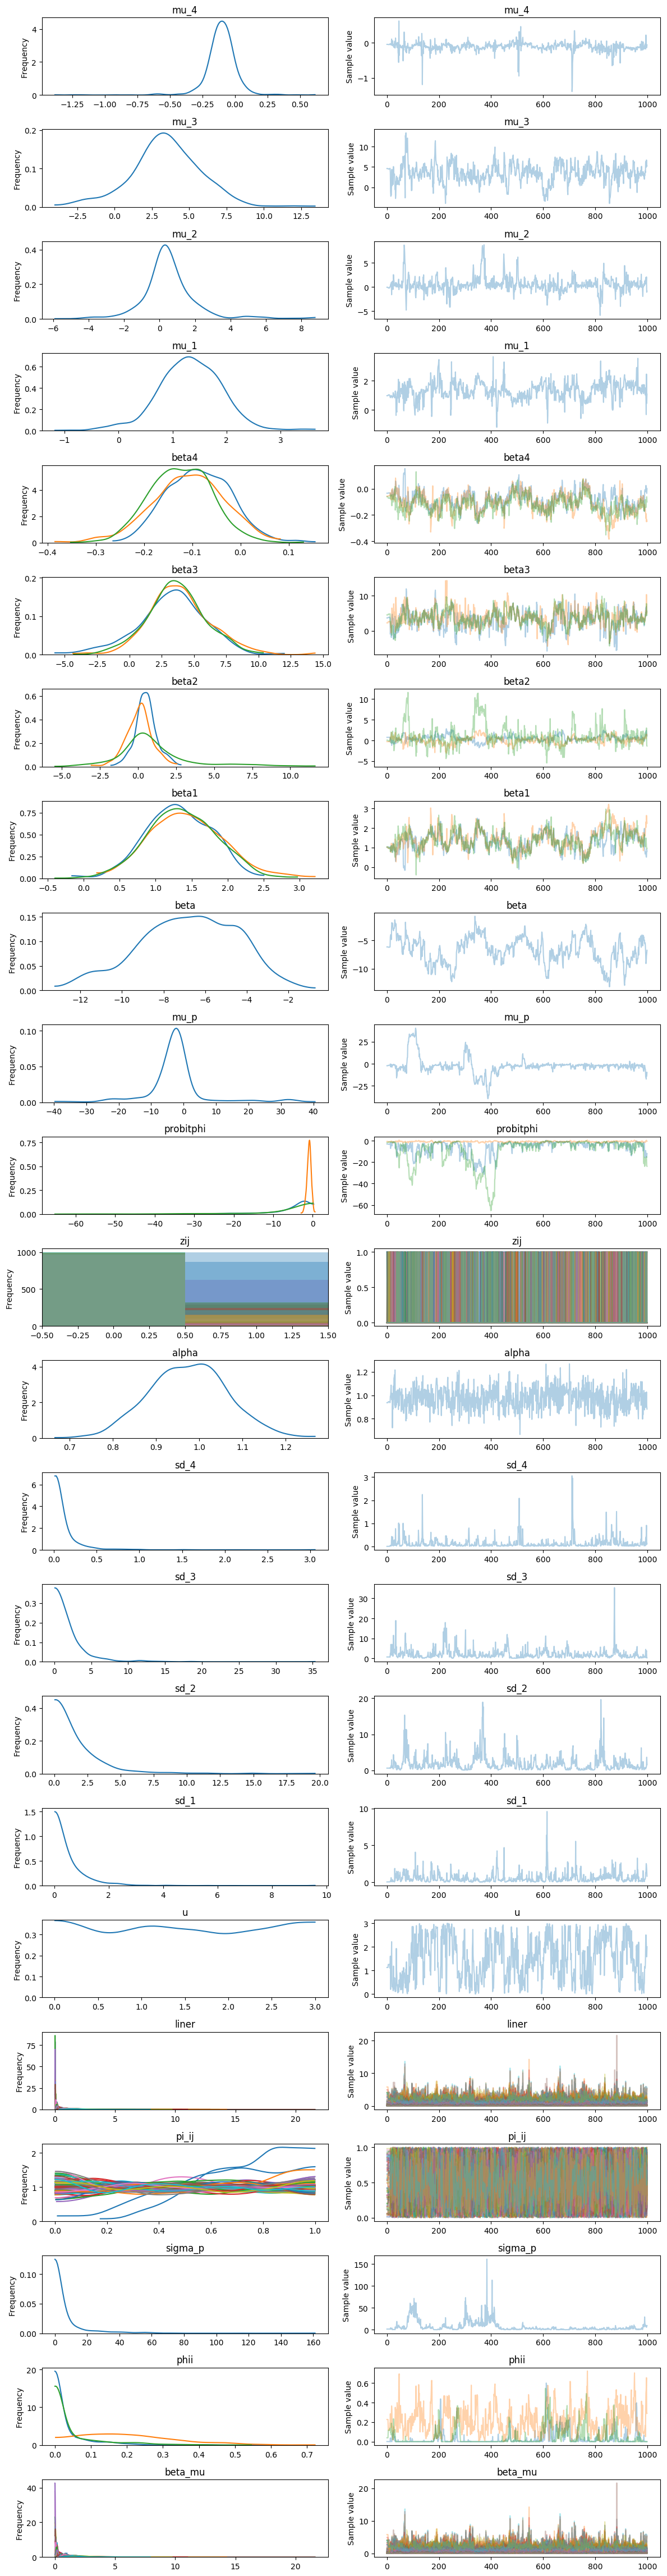

In [10]:
chain_2b = trace_2b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_2b)
plt.show()

              mean        sd  mc_error   hpd_2.5  hpd_97.5
beta2__0  0.700207  0.722888  0.054824 -0.644662  2.056191
beta2__1 -0.203389  0.989323  0.077728 -2.194635  1.411230
beta2__2  0.506001  2.551384  0.189753 -6.094060  5.397490
beta3__0  3.564749  2.830346  0.165473 -2.191916  8.839911
beta3__1  4.558591  2.487228  0.150852 -0.022585  9.131902
beta3__2  3.817053  2.483541  0.186716 -1.389916  7.920551
phii__0   0.023310  0.059623  0.003589  0.000000  0.138868
phii__1   0.219434  0.143994  0.007874  0.004015  0.484007
phii__2   0.037751  0.076220  0.004781  0.000000  0.200555


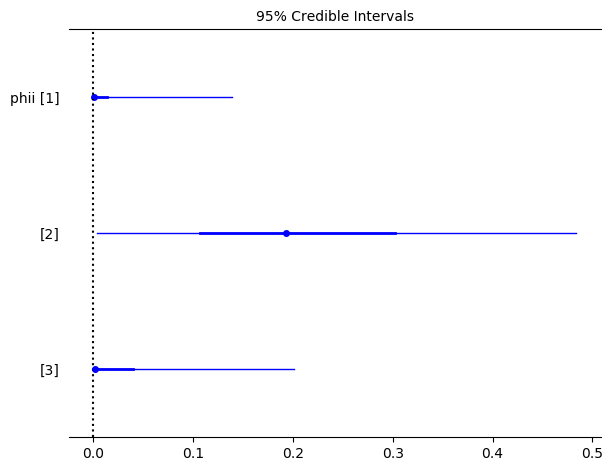

In [11]:
varnames2b = ['beta2', 'beta3','phii']
tmp_2b = pm.df_summary(trace_2b, varnames2b)
print(tmp_2b)
Beta_Mu2b = tmp_2b['mean']

pm.forestplot(trace_2b, varnames=['phii'])
plt.show()

# kde_phii = chain_2b['phii']
# sns.boxplot(x="day", y="total_bill", hue="time", data=kde_phii);

# kde_phii = chain_2b['phii']
# from scipy.stats.kde import gaussian_kde
# ax1 = plt.subplot(1,1,1)
# my_pdf1 = gaussian_kde(kde_phii[:, 0])
# x1 = np.linspace(-0.5, 1, 300)
# ax1.plot(x1, my_pdf1(x1), 'k', lw=2.5, alpha=0.6)
# # print(trace_2b['phii'])
# # pm.plot_posterior(trace_2b, varnames=['phii'], color='#87ceeb')
# plt.show()

In [12]:
varnames2b = ['beta_mu']
varnames2b = ['liner']
tmp_mu2b = pm.df_summary(chain_2b, varnames2b)
Beta_Mu2b = tmp_mu2b['mean']

Beta_Mu_2b = np.array([Beta_Mu2b[i*6:(i+1)*6] for i in np.arange(15)])

# print(Beta_Mu2b)
# 将故障率以5组一行形式组成数组,变成：21*6
M2_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
M2_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
M2_elec_char1 = np.array([X_train_M2_char1[i*6:(i+1)*6] for i in np.arange(15)])
M2_elec_char2 = np.array([X_train_M2_char2[i*6:(i+1)*6] for i in np.arange(15)])

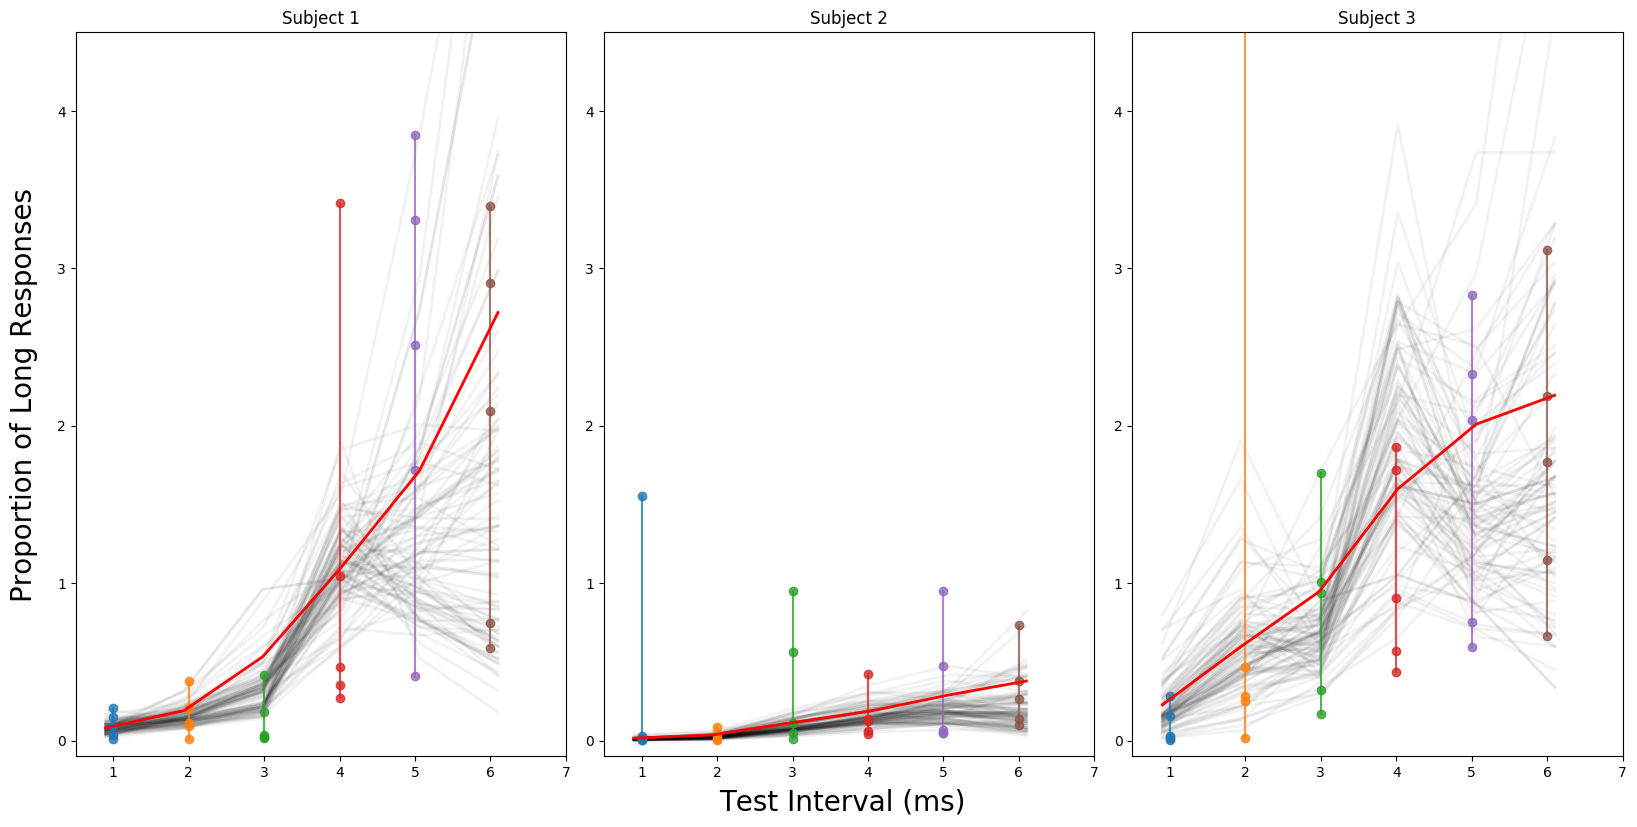

In [13]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = M2_elec_year2[ip*5:(ip+1)*5, :]
    yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
    

    xl = np.linspace(0.9, 6.1, 6)
#     yl = Beta_Mu2[ip*7:(ip+1)*7, :]
#     yl = yl.mean(axis=0)
    
    y2 = Beta_Mu_2b[ip*5:(ip+1)*5, :]
    y2 = y2.mean(axis=0)
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_2b[ips]
        yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
#     plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [14]:
WAIC_2 = pm.waic(trace_2b, model_2b)
print(WAIC_2)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=34.99743454665966, WAIC_se=34.068851718430054, p_WAIC=14.83209336842871)


In [15]:
# 第七年数据测试，读取测试数据集特征,
data_cs = pd.read_csv('XZ_CS_5.csv')
SNR_cs = np.random.normal(0, 2, size=[len(data_cs.Tem.values), 4])
datax_cs = np.array(data_cs)[:,0:4] + SNR_cs # 针对特征添加噪声

data_cs_year = data_cs.Year.values # 测试数据时间
data_cs_num  = data_cs.Count.values # 测试数据参考位置,这么做就是整数

data_cs_num1 =[int(i) for i in data_cs_num] #防止变为64位整数
data_cs_num2 = np.array(data_cs_num1)

meanVal = np.mean(datax_cs, axis=0)  # 按列求均值，即求各个特征的均值
newData_mean = datax_cs - meanVal
StdVal  = np.std(datax_cs, axis=0)
newData_std = newData_mean/StdVal


pca = PCA(n_components=2)
pca.fit(newData_std)
Pca_cs = pca.transform(newData_std) # 测试数据PCA特征值，直接调用即可，但是之调用这条也会出问题
Pca_cs_char1 = Pca_cs[:, 0]
Pca_cs_char2 = Pca_cs[:, 1]
print(data_cs_year)
print(len(data_cs_year))
print(data_cs_num)

[1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 1 2 3 4 5 6 7
 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2 1 2 3 4 5 6 7 1 2 3 4 5 6 7
 1 2 3 4 5 6 7 1 2 3 4 5 6 7 1 2]
90
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2597.32it/s]


[0. 0. 0. 1. 2. 3. 5.]


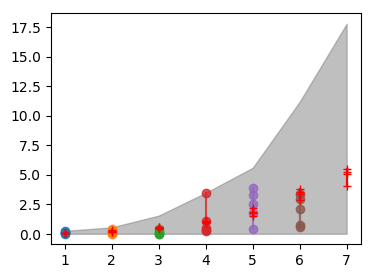

[0. 0. 0. 0. 0. 0. 1.]


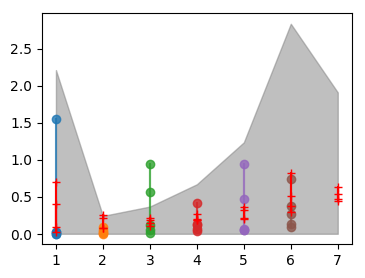

[0. 0. 1. 1. 2. 2. 2.]


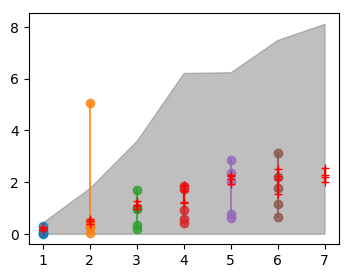

[[0. 0. 0. 1. 2. 3. 5.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 2. 2. 2.]]


In [16]:
# 测试数据结果显示

M2_xs_year.set_value(np.asarray(data_cs_year))
M2_Num_shared.set_value(np.asarray(data_cs_num2))
M2_xs_char1.set_value(np.asarray(Pca_cs_char1))
M2_xs_char2.set_value(np.asarray(Pca_cs_char2))


with model_2b:
    ppcc = pm.sample_ppc(trace_2b)
# print(ppcc)
post_pred = ppcc['Observed']
yipred_mean = post_pred.mean(axis=0)  # 预测均值
# print(yipred_mean)
# 这句话要改
sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
M2_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# print(sig0)
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = M2_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

xp_0 = [1,2,3,4,5,6,7]

plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
M2_Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(M2_Pred_yplot_Mean_A)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 1
xp = M2_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M2_Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(M2_Pred_yplot_Mean_B)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = M2_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M2_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M2_Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(M2_Pred_yplot_Mean_C)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()


M2_Pred_yplot_Mean_C = np.vstack((M2_Pred_yplot_Mean_A, M2_Pred_yplot_Mean_B, M2_Pred_yplot_Mean_C))
print(M2_Pred_yplot_Mean_C)
# np.savetxt('M2_Pred_yplot_Mean_C.csv', M2_Pred_yplot_Mean_C, delimiter = ',')

Bayesian 子模型2
---

In [17]:
X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
Y = elec_faults
M3_X_train, X_test, M3_Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
print(np.shape(X_train))
# print(Y_train)
X_train_M1_year = elec_year[0:len(X_train)] #防止变为浮点数
X_train_M3_char1 = M3_X_train[:, 1]
X_train_M3_char2 = M3_X_train[:, 2]
X_train_M1_ABC = M3_X_train[:, 3]
X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
M3_companyABC = np.array(X_train_M1_ABC)

Y_train_M1_faults = M3_Y_train


# 共享变量设置
M3_xs_char1 = shared(np.asarray(X_train_M3_char1))
M3_xs_char2 = shared(np.asarray(X_train_M3_char2))

M3_ys_faults = shared(np.asarray(Y_train_M1_faults))
M3_xs_year = shared(np.asarray(X_train_M1_year))
M3_Num_shared = shared(np.asarray(M3_companyABC))

print(M3_companyABC)
print(X_train_M1_year)

[ 1  6  9 10 17 19]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1
 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2
 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6]


In [18]:
# 建模，加上含污染模型对比
with pm.Model() as model_3:
    # define priors
    sdsd = 3
    M3_alpha = pm.HalfCauchy('M3_alpha', 10, testval=.6)

    M3_mu_4 = pm.Normal('M3_mu_4', mu=0, tau=.001)
    M3_sd_4 = pm.HalfCauchy('M3_sd_4', sdsd)
    M3_mu_3 = pm.Normal('M3_mu_3', mu=0, tau=.001)
    M3_sd_3 = pm.HalfCauchy('M3_sd_3', sdsd)
    M3_mu_2 = pm.Normal('M3_mu_2', mu=0, tau=.001)
    M3_sd_2 = pm.HalfCauchy('M3_sd_2', sdsd)
    M3_mu_1 = pm.Normal('M3_mu_1', mu=0, tau=.001)
    M3_sd_1 = pm.HalfCauchy('M3_sd_1', sdsd)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd = pm.InverseGamma('sd',3, 0.0001)
    beta4 = pm.Normal('beta4', M3_mu_4, M3_sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', M3_mu_3, M3_sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', M3_mu_2, M3_sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', M3_mu_1, M3_sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M3_Num_shared]**2 + beta4[M3_Num_shared]**2)) + beta + \
                                             (beta1[M3_Num_shared] * M3_xs_year + beta2[M3_Num_shared] * M3_xs_char1 +\
                                              beta3[M3_Num_shared] * M3_xs_char2 + beta4[M3_Num_shared] * M3_xs_year * M3_xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    M3_sigma_p = pm.HalfCauchy('M3_sigma_p', sdsd)
    M3_mu_p = pm.Normal('M3_mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=M3_mu_p, sd=M3_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M3_Num_shared.get_value()))
    
    zij_ = pm.theanof.tt_rng().uniform(size=M3_companyABC.shape)
    zij = pm.Deterministic('zij', tt.lt(zij_, phii[M3_Num_shared]))   

    M3_beta_mu = pm.Deterministic('M3_beta_mu', tt.switch(zij, liner, pi_ij))
    
    M3_Observed = pm.Weibull("M3_Observed", alpha=M3_alpha, beta=M3_beta_mu, observed=M3_ys_faults)  # 观测值

import theano
with model_3:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_3 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

Average Loss = 100.93: 100%|████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 682.50it/s]
Finished [100%]: Average Loss = 100.96
Average Loss = 79.904: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1048.16it/s]
Finished [100%]: Average Loss = 79.867


In [19]:
njob = 1
start = trace_3[0]
start['zij'] = start['zij'].astype(int)
stds = approx.bij.rmap(approx.std.eval())
cov = model_3.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_3b:
    # define priors
    sdsd = 3
    M3_alpha = pm.HalfCauchy('M3_alpha', 10, testval=.6)

    M3_mu_4 = pm.Normal('M3_mu_4', mu=0, tau=.001)
    M3_sd_4 = pm.HalfCauchy('M3_sd_4', sdsd)
    M3_mu_3 = pm.Normal('M3_mu_3', mu=0, tau=.001)
    M3_sd_3 = pm.HalfCauchy('M3_sd_3', sdsd)
    M3_mu_2 = pm.Normal('M3_mu_2', mu=0, tau=.001)
    M3_sd_2 = pm.HalfCauchy('M3_sd_2', sdsd)
    M3_mu_1 = pm.Normal('M3_mu_1', mu=0, tau=.001)
    M3_sd_1 = pm.HalfCauchy('M3_sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    beta4 = pm.Normal('beta4', M3_mu_4, M3_sd_4, shape=companiesABC)
    beta3 = pm.Normal('beta3', M3_mu_3, M3_sd_3, shape=companiesABC)
    beta2 = pm.Normal('beta2', M3_mu_2, M3_sd_2, shape=companiesABC)
    beta1 = pm.Normal('beta1', M3_mu_1, M3_sd_1, shape=companiesABC)
    beta = pm.Normal('beta', 0, 100)
    u = pm.Uniform('u', lower=0,upper=3 )

    liner = pm.Deterministic('liner', tt.exp(u*(tt.sqrt(beta1[M3_Num_shared]**2 + beta4[M3_Num_shared]**2)) + beta + \
                                             (beta1[M3_Num_shared] * M3_xs_year + beta2[M3_Num_shared] * M3_xs_char1 +\
                                              beta3[M3_Num_shared] * M3_xs_char2 + beta4[M3_Num_shared] * M3_xs_year * M3_xs_year)))
    
    pi_ij = pm.Uniform('pi_ij', lower=0, upper=1, shape=len(M3_Num_shared.get_value()))

    # latent model for contamination
    M3_sigma_p = pm.HalfCauchy('M3_sigma_p', sdsd)
    M3_mu_p = pm.Normal('M3_mu_p', mu=0, tau=.001)

    probitphi = pm.Normal('probitphi', mu=M3_mu_p, sd=M3_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    phii = pm.Deterministic('phii', Phi(probitphi))

    zij = pm.Bernoulli('zij', p=phii[M3_Num_shared], shape=len(M3_Num_shared.get_value()))

    M3_beta_mu = pm.Deterministic('M3_beta_mu', tt.switch(tt.eq(zij, 0), liner, pi_ij))

    M3_Observed = pm.Weibull("M3_Observed", alpha=M3_alpha, beta=M3_beta_mu, observed=M3_ys_faults)  # 观测值

    #     step1 = pm.Metropolis([zij])
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace_3b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij
100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [04:23<00:00, 13.26it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.6852000847715852, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 813 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self

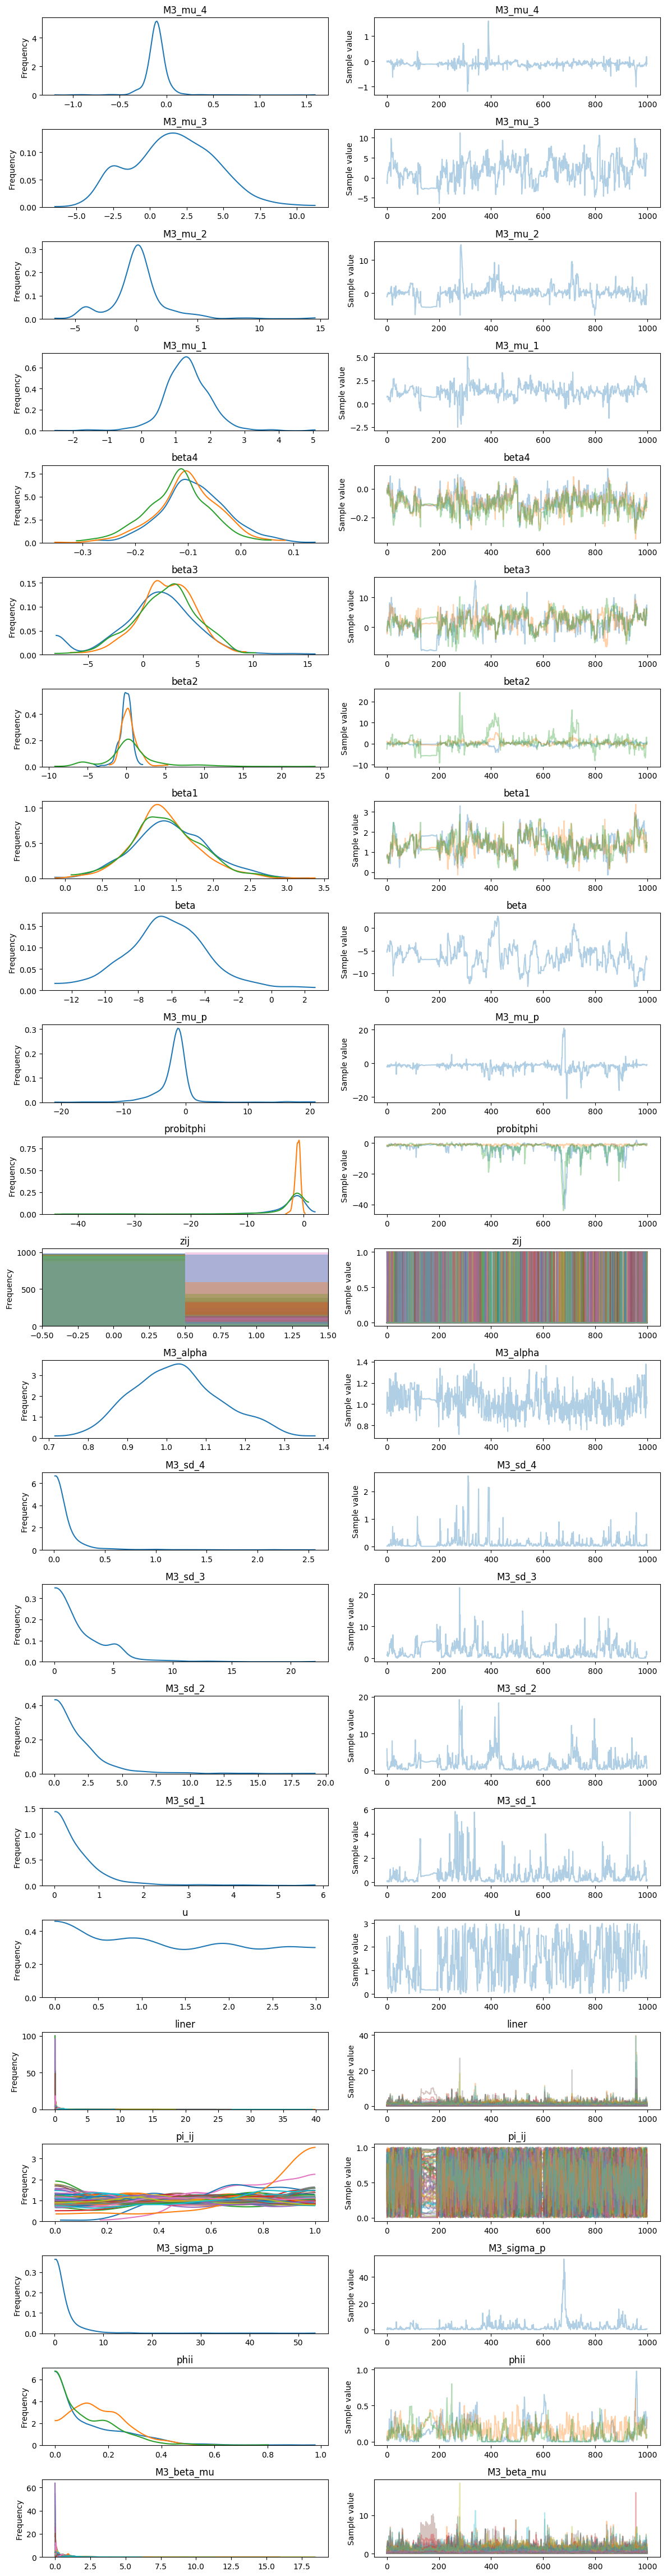

In [20]:
chain_3b = trace_3b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_3b)
plt.show()

             mean        sd  mc_error  hpd_2.5  hpd_97.5
phii__0  0.118849  0.145397  0.012347  0.00000  0.388552
phii__1  0.168174  0.102274  0.007044  0.00201  0.360895
phii__2  0.110459  0.113250  0.009277  0.00000  0.321171


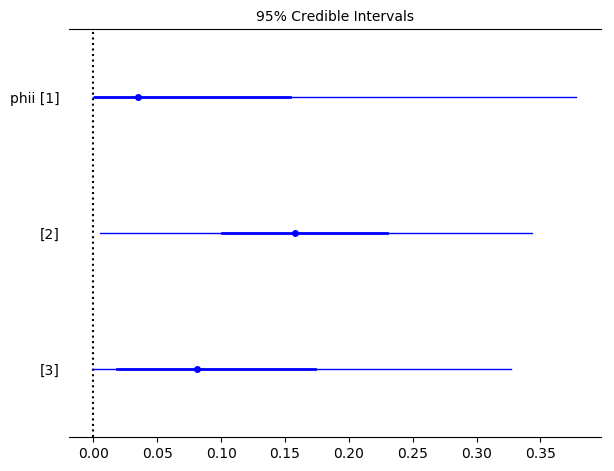

In [21]:
varnames3b = ['phii']
tmp_3b = pm.df_summary(chain_3b, varnames3b)
print(tmp_3b)
pm.forestplot(trace_3b, varnames=['phii'])
plt.show()

In [22]:
# WAIC_3 = pm.waic(trace_3b, model_3b)
# print(WAIC_3)

In [23]:
varnames3b = ['M3_beta_mu']
varnames3b = ['liner']
tmp_mu3b = pm.df_summary(chain_3b, varnames3b)
Beta_Mu3b = tmp_mu3b['mean']

Beta_Mu_3b = np.array([Beta_Mu3b[i*6:(i+1)*6] for i in np.arange(15)])

# print(Beta_Mu2b)
# 将故障率以5组一行形式组成数组,变成：21*6
M3_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
M3_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
M3_elec_char1 = np.array([X_train_M3_char1[i*6:(i+1)*6] for i in np.arange(15)])
M3_elec_char2 = np.array([X_train_M3_char2[i*6:(i+1)*6] for i in np.arange(15)])

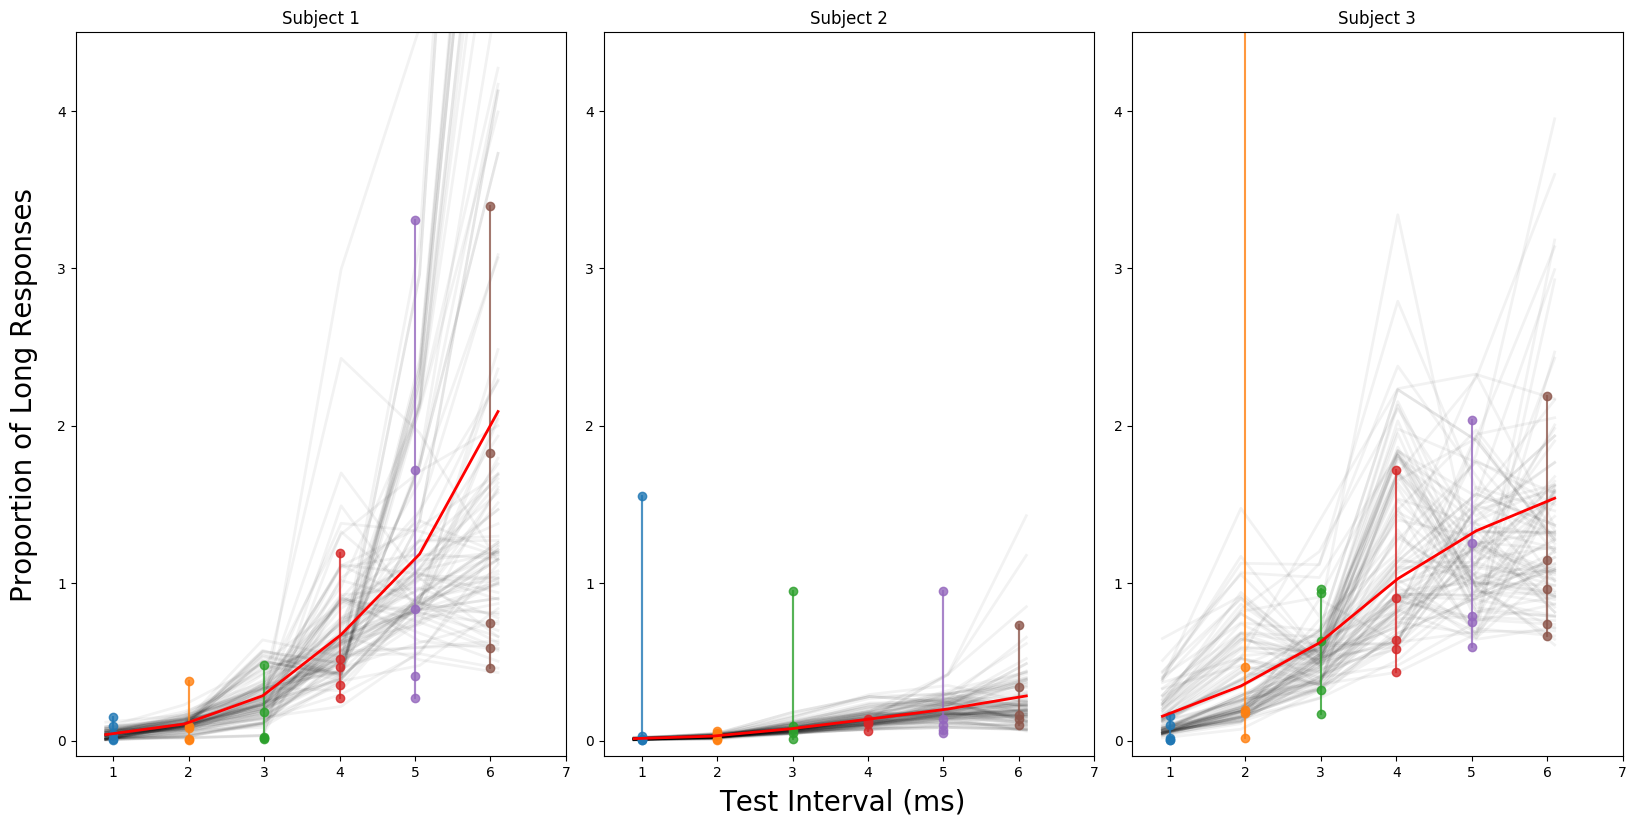

In [24]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = M3_elec_year2[ip*5:(ip+1)*5, :]
    yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
    

    xl = np.linspace(0.9, 6.1, 6)
#     yl = Beta_Mu2[ip*7:(ip+1)*7, :]
#     yl = yl.mean(axis=0)
    
    y2 = Beta_Mu_3b[ip*5:(ip+1)*5, :]
    y2 = y2.mean(axis=0)
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_3b[ips]
        yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
#     plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [25]:
WAIC_3 = pm.waic(trace_3b, model_3b)
print(WAIC_3)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-30.808403340060853, WAIC_se=33.754137774361475, p_WAIC=17.133238584061594)


100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2838.50it/s]


[0. 0. 0. 1. 1. 2. 3.]


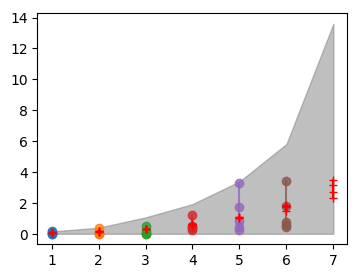

[0. 0. 0. 0. 0. 0. 1.]


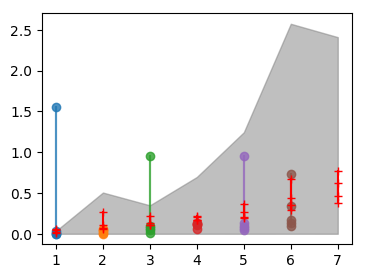

[0. 0. 1. 1. 1. 1. 2.]


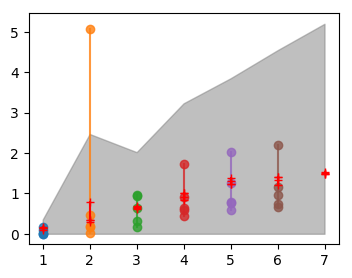

[[0. 0. 0. 1. 1. 2. 3.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 2.]]


In [26]:
# 测试数据结果显示

M3_xs_year.set_value(np.asarray(data_cs_year))
M3_Num_shared.set_value(np.asarray(data_cs_num2))
M3_xs_char1.set_value(np.asarray(Pca_cs_char1))
M3_xs_char2.set_value(np.asarray(Pca_cs_char2))


with model_3b:
    ppcc = pm.sample_ppc(trace_3b)
# print(ppcc)
post_pred = ppcc['M3_Observed']
yipred_mean = post_pred.mean(axis=0)  # 预测均值
# print(yipred_mean)
# 这句话要改
sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
M3_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# print(sig0)
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

xp_0 = [1,2,3,4,5,6,7]

plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
M3_Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(M3_Pred_yplot_Mean_A)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 1
xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M3_Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(M3_Pred_yplot_Mean_B)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = M3_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M3_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M3_Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(M3_Pred_yplot_Mean_C)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()

M3_Pred_yplot_Mean_C = np.vstack((M3_Pred_yplot_Mean_A, M3_Pred_yplot_Mean_B, M3_Pred_yplot_Mean_C))
print(M3_Pred_yplot_Mean_C)
# np.savetxt('M3_Pred_yplot_Mean_C.csv', M3_Pred_yplot_Mean_C, delimiter = ',')

Bayesian 子模型3
---

In [27]:
X = np.vstack((elec_year, elec_Pca_char1, elec_Pca_char2, companyABC)).T
Y = elec_faults
M4_X_train, X_test, M4_Y_train, Y_test = DataSplit(X, Y, test_size=.2) #随机分离原始数据
print(np.shape(X_train))
# print(Y_train)
X_train_M1_year = elec_year[0:len(M4_X_train)] #防止变为浮点数
X_train_M4_char1 = M4_X_train[:, 1]
X_train_M4_char2 = M4_X_train[:, 2]
X_train_M1_ABC = M4_X_train[:, 3]
X_train_M1_ABC =[int(i) for i in X_train_M1_ABC] #防止变为浮点数
M4_companyABC = np.array(X_train_M1_ABC)

Y_train_M4_faults = M4_Y_train


# 共享变量设4置
M4_xs_char1 = shared(np.asarray(X_train_M4_char1))
M4_xs_char2 = shared(np.asarray(X_train_M4_char2))

M4_ys_faults = shared(np.asarray(Y_train_M4_faults))
M4_xs_year = shared(np.asarray(X_train_M1_year))
M4_Num_shared = shared(np.asarray(M4_companyABC))
# M2_companyABC = companyABC

print(M4_companyABC)
print(X_train_M1_year)

[ 0  2 10 11 14 17]
(90, 4)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1
 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2
 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6]


In [28]:
# 建模，加上含污染模型对比
with pm.Model() as model_4:
    # define priors
    sdsd = 3
    M4_alpha = pm.HalfCauchy('M4_alpha', 10, testval=.6)

    M4_mu_4 = pm.Normal('M4_mu_4', mu=0, tau=.001)
    M4_sd_4 = pm.HalfCauchy('M4_sd_4', sdsd)
    M4_mu_3 = pm.Normal('M4_mu_3', mu=0, tau=.001)
    M4_sd_3 = pm.HalfCauchy('M4_sd_3', sdsd)
    M4_mu_2 = pm.Normal('M4_mu_2', mu=0, tau=.001)
    M4_sd_2 = pm.HalfCauchy('M4_sd_2', sdsd)
    M4_mu_1 = pm.Normal('M4_mu_1', mu=0, tau=.001)
    M4_sd_1 = pm.HalfCauchy('M4_sd_1', sdsd)
#     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
#     sd_0 = pm.HalfCauchy('sd_0', 20)
#     sd = pm.InverseGamma('sd',3, 0.0001)
    M4_beta4 = pm.Normal('M4_beta4', M4_mu_4, M4_sd_4, shape=companiesABC)
    M4_beta3 = pm.Normal('M4_beta3', M4_mu_3, M4_sd_3, shape=companiesABC)
    M4_beta2 = pm.Normal('M4_beta2', M4_mu_2, M4_sd_2, shape=companiesABC)
    M4_beta1 = pm.Normal('M4_beta1', M4_mu_1, M4_sd_1, shape=companiesABC)
    M4_beta = pm.Normal('M4_beta', 0, 100)
    M4_u = pm.Uniform('M3_u', lower=0,upper=3 )

    liner1 = pm.Deterministic('liner1', tt.exp(M4_u*(tt.sqrt(M4_beta1[M4_Num_shared]**2 + M4_beta4[M4_Num_shared]**2)) + M4_beta + \
                                             (M4_beta1[M4_Num_shared] * M4_xs_year + M4_beta2[M4_Num_shared] * M4_xs_char1 +\
                                              M4_beta3[M4_Num_shared] * M4_xs_char2 + M4_beta4[M4_Num_shared] * M4_xs_year * M4_xs_year)))

    # latent model for contamination
#     upper = pm.HalfCauchy('upper', 10)
    M4_sigma_p = pm.HalfCauchy('M4_sigma_p', sdsd)
    M4_mu_p = pm.Normal('M4_mu_p', mu=0, tau=.001)

    M4_probitphi = pm.Normal('M4_probitphi', mu=M4_mu_p, sd=M4_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    M4_phii = pm.Deterministic('M4_phii', Phi(M4_probitphi))
    
    pi_ij1 = pm.Uniform('pi_ij1', lower=0, upper=1, shape=len(M4_Num_shared.get_value()))
    
    M4_zij_ = pm.theanof.tt_rng().uniform(size=M4_companyABC.shape)
    zij1 = pm.Deterministic('zij1', tt.lt(M4_zij_, M4_phii[M4_Num_shared]))   

    beta_mu1 = pm.Deterministic('beta_mu1', tt.switch(zij1, liner1, pi_ij1))
    
    M4_Observed = pm.Weibull("M4_Observed", alpha=M4_alpha, beta=beta_mu1, observed=M4_ys_faults)  # 观测值

import theano
with model_4:
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace_4 = approx.sample(3000, include_transformed=True)
    elbos1 = -inference.hist

Average Loss = 125.27: 100%|████████████████████████████████████████████████████| 20000/20000 [00:28<00:00, 702.96it/s]
Finished [100%]: Average Loss = 125.5
Average Loss = 104.22: 100%|███████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1037.25it/s]
Finished [100%]: Average Loss = 104.16


In [29]:
njob = 1
start = trace_4[0]
start['zij1'] = start['zij1'].astype(int)
stds = approx.bij.rmap(approx.std.eval())
cov = model_4.dict_to_array(stds) ** 2
# 建模，加上含污染模型对比
with pm.Model() as model_4b:
    # define priors
    sdsd = 3
    M4_alpha = pm.HalfCauchy('alpha', 10, testval=.6)

    M4_mu_4 = pm.Normal('M4_mu_4', mu=0, tau=.001)
    M4_sd_4 = pm.HalfCauchy('M4_sd_4', sdsd)
    M4_mu_3 = pm.Normal('M4_mu_3', mu=0, tau=.001)
    M4_sd_3 = pm.HalfCauchy('M4_sd_3', sdsd)
    M4_mu_2 = pm.Normal('M4_mu_2', mu=0, tau=.001)
    M4_sd_2 = pm.HalfCauchy('M4_sd_2', sdsd)
    M4_mu_1 = pm.Normal('M4_mu_1', mu=0, tau=.001)
    M4_sd_1 = pm.HalfCauchy('M4_sd_1', sdsd)
    #     mu_0 = pm.Normal('mu_0', mu=0, tau=.001)
    #     sd_0 = pm.HalfCauchy('sd_0', 20)
    M4_beta4 = pm.Normal('M4_beta4', M4_mu_4, M4_sd_4, shape=companiesABC)
    M4_beta3 = pm.Normal('M4_beta3', M4_mu_3, M4_sd_3, shape=companiesABC)
    M4_beta2 = pm.Normal('M4_beta2', M4_mu_2, M4_sd_2, shape=companiesABC)
    M4_beta1 = pm.Normal('M4_beta1', M4_mu_1, M4_sd_1, shape=companiesABC)
    M4_beta = pm.Normal('M4_beta', 0, 100)
    M4_u = pm.Uniform('M4_u', lower=0,upper=3 )

    liner1 = pm.Deterministic('liner1', tt.exp(M4_u*(tt.sqrt(M4_beta1[M4_Num_shared]**2 + M4_beta4[M4_Num_shared]**2)) + M4_beta + \
                                             (M4_beta1[M4_Num_shared] * M4_xs_year + M4_beta2[M4_Num_shared] * M4_xs_char1 +\
                                              M4_beta3[M4_Num_shared] * M4_xs_char2 + M4_beta4[M4_Num_shared] * M4_xs_year * M4_xs_year)))
    
    pi_ij1 = pm.Uniform('pi_ij1', lower=0, upper=1, shape=len(M4_Num_shared.get_value()))

    # latent model for contamination
    M4_sigma_p = pm.HalfCauchy('M4_sigma_p', sdsd)
    M4_mu_p = pm.Normal('M4_mu_p', mu=0, tau=.001)

    M4_probitphi = pm.Normal('M4_probitphi', mu=M4_mu_p, sd=M4_sigma_p, shape=companiesABC, testval=np.ones(companiesABC))
    M4_phii = pm.Deterministic('M4_phii', Phi(M4_probitphi))

    zij1 = pm.Bernoulli('zij1', p=M4_phii[M4_Num_shared], shape=len(M4_Num_shared.get_value()))

    beta_mu1 = pm.Deterministic('beta_mu1', tt.switch(tt.eq(zij1, 0), liner1, pi_ij1))

    M4_Observed = pm.Weibull("M4_Observed", alpha=M4_alpha, beta=beta_mu1, observed=M4_ys_faults)  # 观测值

    #     step1 = pm.Metropolis([zij])
    step = pm.NUTS(scaling=cov, is_cov=True)
    trace_4b = pm.sample(3000, step=[step], start=start, njobs=njob, turn=500)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Assigned BinaryGibbsMetropolis to zij1
100%|█████████████████████████████████████████████████████████████████████████████▉| 3497/3500 [03:24<00:00, 17.14it/s]D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.453079030785316, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1578 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (sel

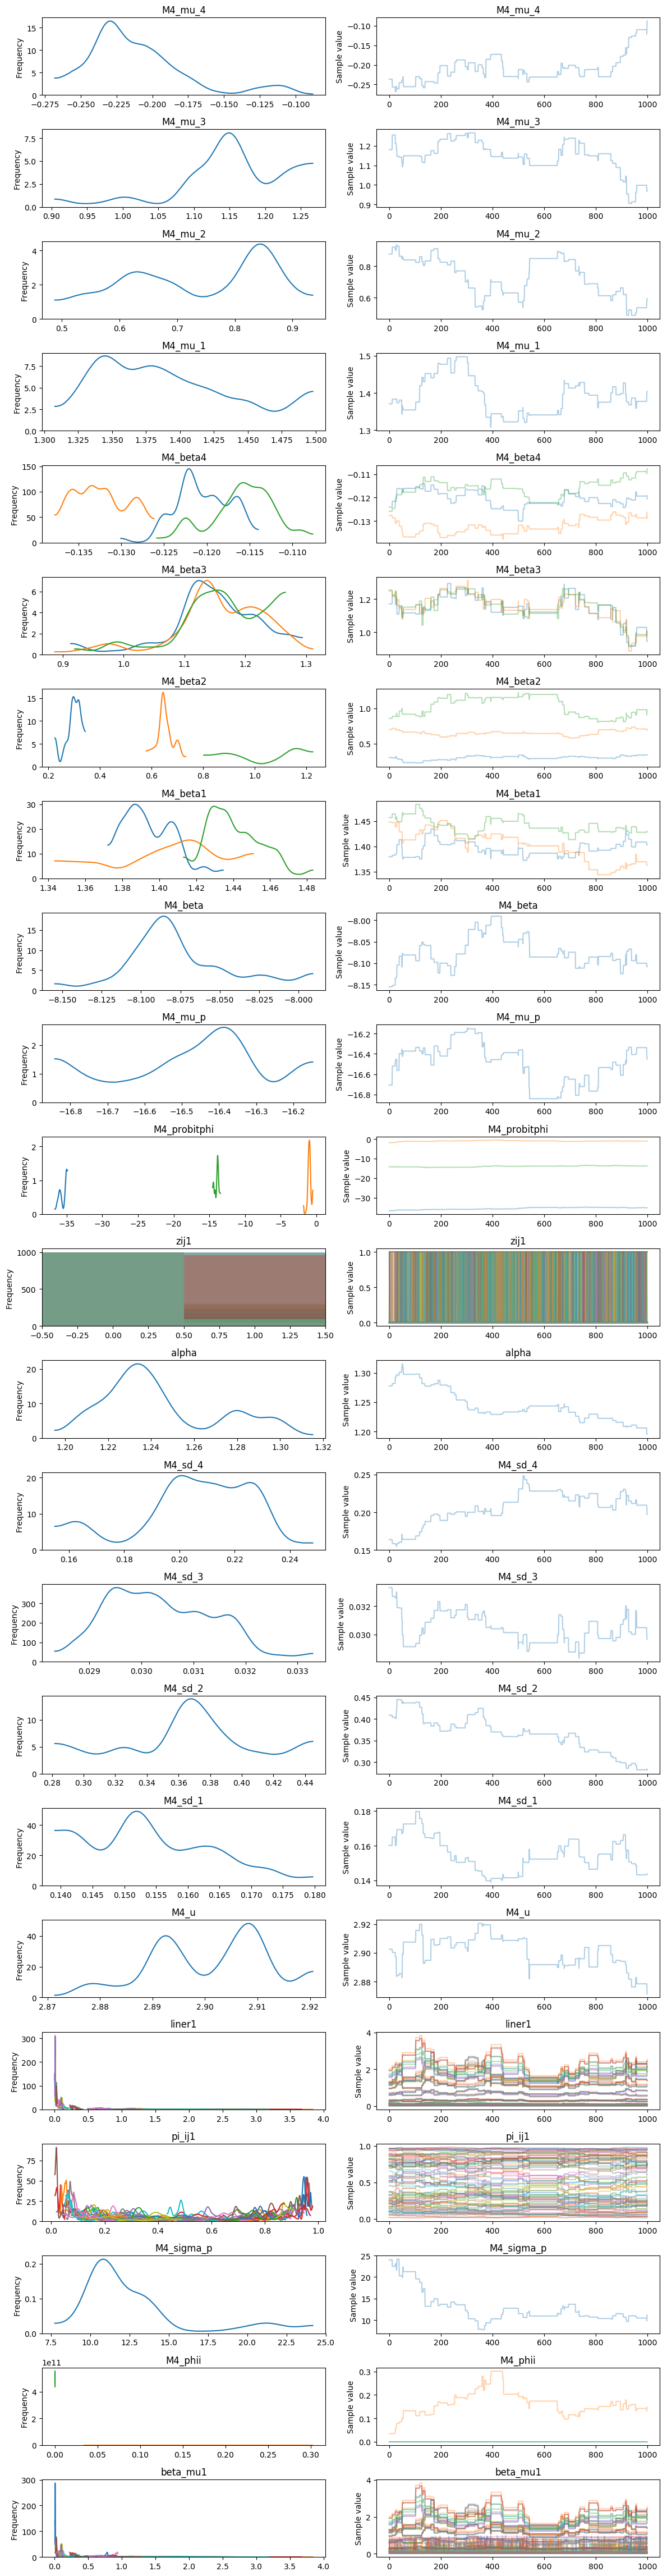

In [30]:
chain_4b = trace_4b[2000:]
# varnames2 = ['beta', 'beta1', 'beta2', 'beta3', 'u', 'beta4']
pm.traceplot(chain_4b)
plt.show()

                mean        sd  mc_error   hpd_2.5  hpd_97.5
M4_phii__0  0.000000  0.000000  0.000000  0.000000   0.00000
M4_phii__1  0.162741  0.051599  0.005102  0.096078   0.30237
M4_phii__2  0.000000  0.000000  0.000000  0.000000   0.00000


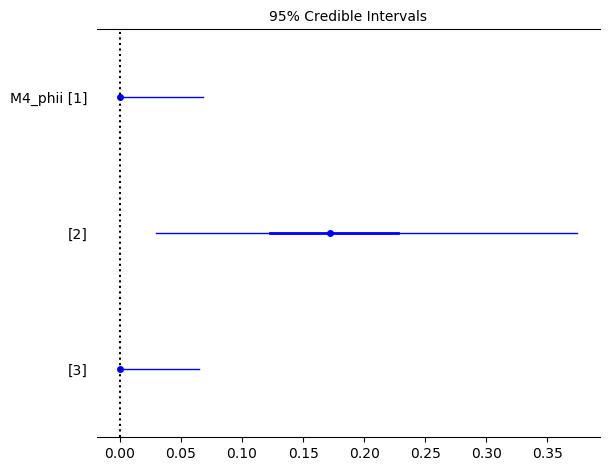

In [31]:
varnames4b = ['M4_phii']
tmp_4b = pm.df_summary(chain_4b, varnames4b)
print(tmp_4b)
pm.forestplot(trace_4b, varnames=['M4_phii'])
plt.show()

In [32]:
WAIC_4 = pm.waic(trace_4b, model_4b)
print(WAIC_4)
# LOO_4 = pm.loo(chain_4b, model_4b)
# print(LOO_4)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=-19.61193431875831, WAIC_se=31.008415446243593, p_WAIC=11.463605072615037)


In [33]:
varnames4b = ['liner1']
tmp_mu4b = pm.df_summary(chain_4b, varnames4b)
Beta_Mu4b = tmp_mu4b['mean']

Beta_Mu_4b = np.array([Beta_Mu4b[i*6:(i+1)*6] for i in np.arange(15)])

# print(Beta_Mu2b)
# 将故障率以5组一行形式组成数组,变成：21*6
M4_elec_faults2 = np.array([Y_train_M1_faults[i*6:(i+1)*6] for i in np.arange(15)])
M4_elec_year2 = np.array([X_train_M1_year[i*6:(i+1)*6] for i in np.arange(15)])
M4_elec_char1 = np.array([X_train_M4_char1[i*6:(i+1)*6] for i in np.arange(15)])
M4_elec_char2 = np.array([X_train_M4_char2[i*6:(i+1)*6] for i in np.arange(15)])

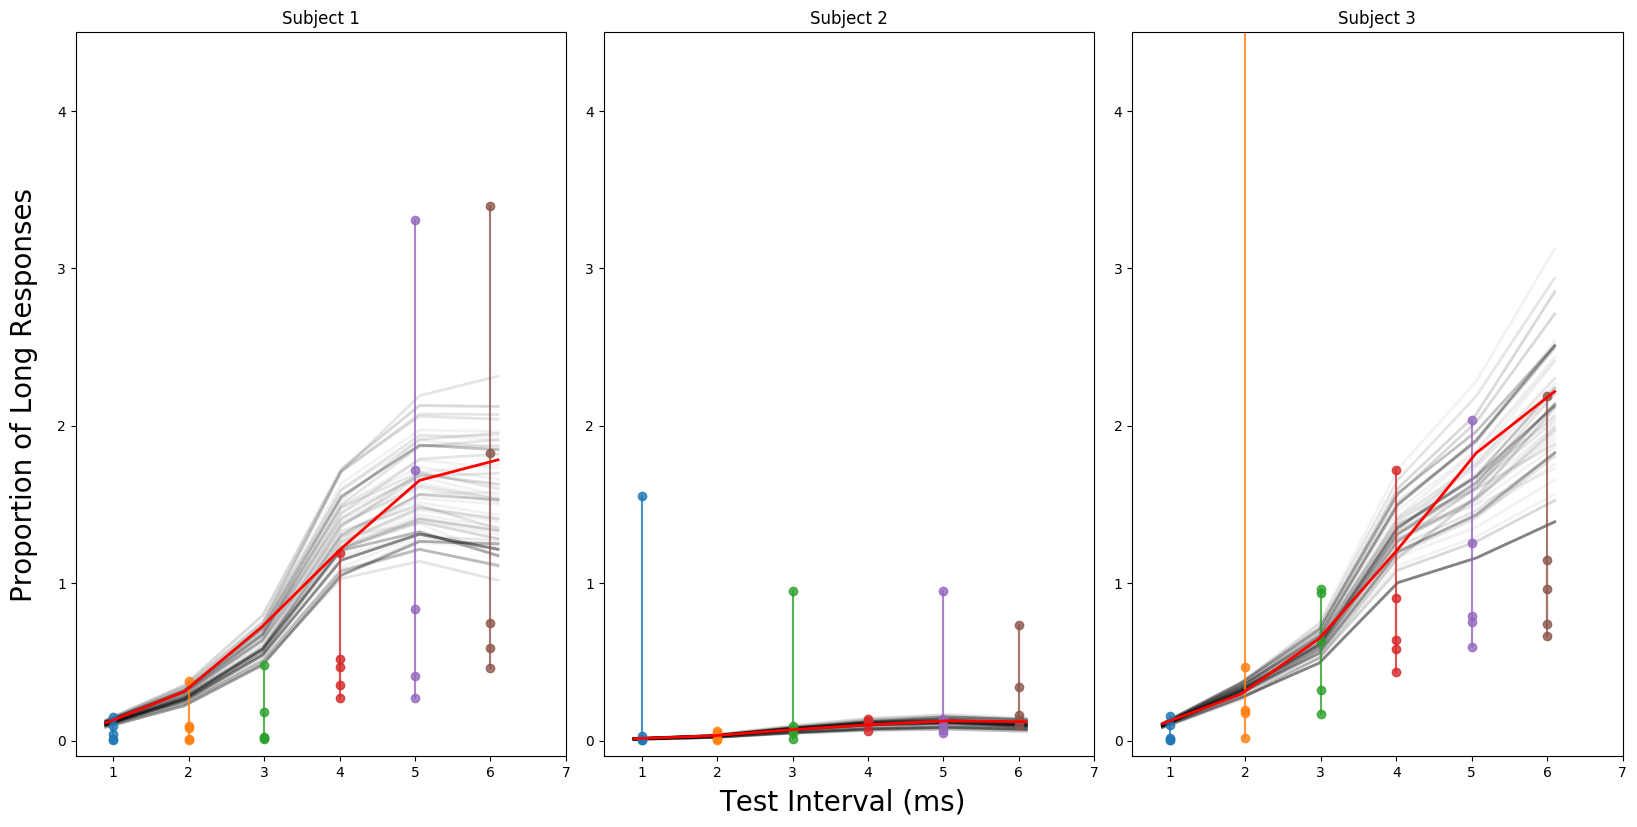

In [34]:
# 模型拟合效果图
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = M4_elec_year2[ip*5:(ip+1)*5, :]
    yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
    

    xl = np.linspace(0.9, 6.1, 6)
#     yl = Beta_Mu2[ip*7:(ip+1)*7, :]
#     yl = yl.mean(axis=0)
    
    y2 = Beta_Mu_4b[ip*5:(ip+1)*5, :]
    y2 = y2.mean(axis=0)
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_4b[ips]
        yl2 = np.exp(param['M4_u']*(np.sqrt(param['M4_beta1'][ip]**2 + param['M4_beta4'][ip]**2)) + param['M4_beta'] + (param['M4_beta1'][ip] * (xl) + \
                     param['M4_beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['M4_beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['M4_beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
#     plt.plot(xl, yl, 'k--', linewidth=2)
    plt.plot(xl, y2,  'r', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2999.18it/s]


[0. 0. 1. 1. 2. 2. 3.]


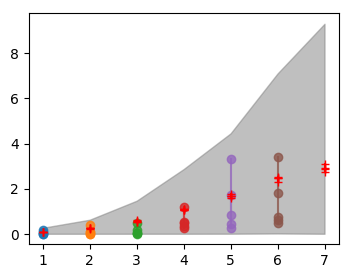

[0. 0. 0. 0. 0. 0. 1.]


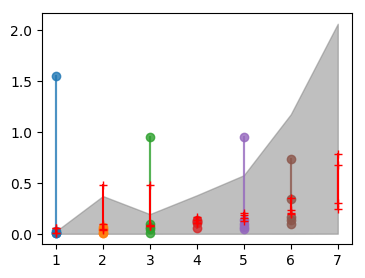

[0. 0. 1. 1. 2. 2. 2.]


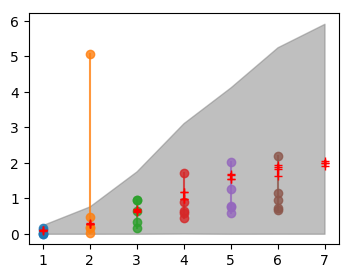

[[0. 0. 1. 1. 2. 2. 3.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 2. 2. 2.]]


In [35]:
# 测试数据结果显示

M4_xs_year.set_value(np.asarray(data_cs_year))
M4_Num_shared.set_value(np.asarray(data_cs_num2))
M4_xs_char1.set_value(np.asarray(Pca_cs_char1))
M4_xs_char2.set_value(np.asarray(Pca_cs_char2))


with model_4b:
    ppcc = pm.sample_ppc(trace_4b)
# print(ppcc)
post_pred = ppcc['M4_Observed']
yipred_mean = post_pred.mean(axis=0)  # 预测均值
# print(yipred_mean)
# 这句话要改
sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
M4_sig0 = pm.hpd(post_pred, alpha=0.05)   # 预测置信区间
# plt.fill_between(xp, sig0[:,0], sig01[:,1], color='gray', alpha=.8)  
# print(sig0)
# 预测，此时这种格式是每行列数len(elec_faults)个，有很多行数据
xipred={}

fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 0
xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

xp_0 = [1,2,3,4,5,6,7]

plt.fill_between(xp_0, sig0[:7,0], sig0[:7,1], color='gray', alpha=.5) 

yipred_yplot = np.array([yipred_mean[i*7:(i+1)*7] for i in np.arange(4*ip, (ip+1)*4)])
Pred_yplot_Mean_A = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_A)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')  
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred0.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 1
xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[30:37,0], sig0[30:37,1], color='gray', alpha=.5) 


yipred_yplot = np.array([yipred_mean[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
Pred_yplot_Mean_B = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_B)
xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r') 
# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred1.png', dpi = 200, bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
ip = 2
xp = M4_elec_year2[ip*5:(ip+1)*5, :]  #原始数据
yp = M4_elec_faults2[ip*5:(ip+1)*5, :]
ax.plot(xp, yp, marker='o', alpha=.8)

plt.fill_between(xp_0, sig0[60:67,0], sig0[60:67,1], color='gray', alpha=.5)  

yipred_yplot = np.array([yipred_mean[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
Pred_yplot_Mean_C = yipred_yplot.mean(axis=0)
print(Pred_yplot_Mean_C)

xipred = np.array([np.arange(7)+1 for i in np.arange(4)])
ax.plot(xipred, yipred_yplot[:], 'k+-', color='r')

# plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\Picture\\Pred2.png', dpi = 200, bbox_inches='tight')
plt.show()


M4_Pred_yplot_Mean_C = np.vstack((Pred_yplot_Mean_A, Pred_yplot_Mean_B, Pred_yplot_Mean_C))
print(M4_Pred_yplot_Mean_C)
# np.savetxt('M4_Pred_yplot_Mean_C.csv', M4_Pred_yplot_Mean_C, delimiter = ',')

In [36]:
#保存预测的置信区间
print(np.shape(M4_sig0.T))


PhdMin = M2_sig0.T[0]
PhdMax = M2_sig0.T[1]
ip = 0
M2_PhdMin = np.array([PhdMin[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMin_A = M2_PhdMin.mean(axis=0)
M2_PhdMax = np.array([PhdMax[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMax_A = M2_PhdMax.mean(axis=0)


ip = 1
M2_PhdMin = np.array([PhdMin[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMin_B = M2_PhdMin.mean(axis=0)
M2_PhdMax = np.array([PhdMax[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMax_B = M2_PhdMax.mean(axis=0)

ip = 2
M2_PhdMin = np.array([PhdMin[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMin_C = M2_PhdMin.mean(axis=0)
M2_PhdMax = np.array([PhdMax[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M2_PhdMax_C = M2_PhdMax.mean(axis=0)



PhdMin = M3_sig0.T[0]
PhdMax = M3_sig0.T[1]
ip = 0
M3_PhdMin = np.array([PhdMin[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMin_A = M3_PhdMin.mean(axis=0)
M3_PhdMax = np.array([PhdMax[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMax_A = M3_PhdMax.mean(axis=0)


ip = 1
M3_PhdMin = np.array([PhdMin[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMin_B = M3_PhdMin.mean(axis=0)
M3_PhdMax = np.array([PhdMax[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMax_B = M3_PhdMax.mean(axis=0)

ip = 2
M3_PhdMin = np.array([PhdMin[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMin_C = M3_PhdMin.mean(axis=0)
M3_PhdMax = np.array([PhdMax[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M3_PhdMax_C = M3_PhdMax.mean(axis=0)



# print(sig0.T)
PhdMin = M4_sig0.T[0]
PhdMax = M4_sig0.T[1]
ip = 0
M4_PhdMin = np.array([PhdMin[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMin_A = M4_PhdMin.mean(axis=0)
M4_PhdMax = np.array([PhdMax[(i*7):((i+1)*7)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMax_A = M4_PhdMax.mean(axis=0)


ip = 1
M4_PhdMin = np.array([PhdMin[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMin_B = M4_PhdMin.mean(axis=0)
M4_PhdMax = np.array([PhdMax[(i*7+2):((i+1)*7+2)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMax_B = M4_PhdMax.mean(axis=0)

ip = 2
M4_PhdMin = np.array([PhdMin[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMin_C = M4_PhdMin.mean(axis=0)
M4_PhdMax = np.array([PhdMax[(i*7+4):((i+1)*7+4)] for i in np.arange(4*ip, (ip+1)*4)])
M4_PhdMax_C = M4_PhdMax.mean(axis=0)

A_PhdMaxMin0595 = np.vstack((M2_PhdMin_A, M3_PhdMin_A, M4_PhdMin_A, M2_PhdMax_A, M3_PhdMax_A, M4_PhdMax_A))
print(A_PhdMaxMin0595)
B_PhdMaxMin0595 = np.vstack((M2_PhdMin_B, M3_PhdMin_B, M4_PhdMin_B, M2_PhdMax_B, M3_PhdMax_B, M4_PhdMax_B))
print(B_PhdMaxMin0595)
C_PhdMaxMin0595 = np.vstack((M2_PhdMin_C, M3_PhdMin_C, M4_PhdMin_C, M2_PhdMax_C, M3_PhdMax_C, M4_PhdMax_C))
print(C_PhdMaxMin0595)
# np.savetxt('A_PhdMaxMin0595.csv', A_PhdMaxMin0595, delimiter = ',')
# np.savetxt('B_PhdMaxMin0595.csv', B_PhdMaxMin0595, delimiter = ',')
# np.savetxt('C_PhdMaxMin0595.csv', C_PhdMaxMin0595, delimiter = ',')

(2, 90)
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  2.  3.  6. 11. 17.]
 [ 0.  1.  1.  2.  3.  6. 11.]
 [ 0.  1.  1.  3.  4.  7. 10.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 2. 2.]
 [0. 1. 1. 1. 1. 2. 2.]
 [0. 1. 1. 0. 0. 1. 1.]]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 2. 4. 5. 7. 7. 8.]
 [1. 1. 2. 3. 4. 4. 6.]
 [0. 1. 2. 3. 4. 5. 6.]]


三个子模型综合起来
---

In [37]:
WAIC = pm.compare([chain_2b, chain_3b, chain_4b], [model_2b, model_3b, model_4b], ic='WAIC')
print(WAIC)

      WAIC    pWAIC    dWAIC weight       SE     dSE warning
2  1267.38   444.62        0   0.67   653.05       0       1
0  5375.83  2612.03  4108.45   0.04  2343.73    1767       1
1   394430   197189   393163   0.29   332775  332155       1


In [38]:
WAIC = pm.compare([chain_2b, chain_3b], [model_2b, model_3b], ic='WAIC')
print(WAIC)

      WAIC    pWAIC   dWAIC weight       SE     dSE warning
0  5375.83  2612.03       0    NaN  2343.73       0       1
1   394430   197189  389054    NaN   332775  330852       1


In [39]:
# 计算三个子模型的均值
Mean_output =[]
W_i = [0.37, 0.43, 0.2]
for ip in np.arange(3):

    y1 = Beta_Mu_2b[ip*5:(ip+1)*5, :]
    y1 = y1.mean(axis=0)
#     print(y1)
    y2 = Beta_Mu_3b[ip*5:(ip+1)*5, :]
    y2 = y2.mean(axis=0)
    
    y3 = Beta_Mu_4b[ip*5:(ip+1)*5, :]
    y3 = y3.mean(axis=0)
    
    Mean_output.append((W_i[0]*y1+W_i[1]*y2+W_i[2]*y3))
print(Mean_output)
# print(Beta_Mu_2b)
# np.savetxt('Mean_output.csv', Mean_output, delimiter = ',')

[array([0., 0., 0., 1., 1., 2.]), array([0., 0., 0., 0., 0., 0.]), array([0., 0., 1., 1., 2., 2.])]


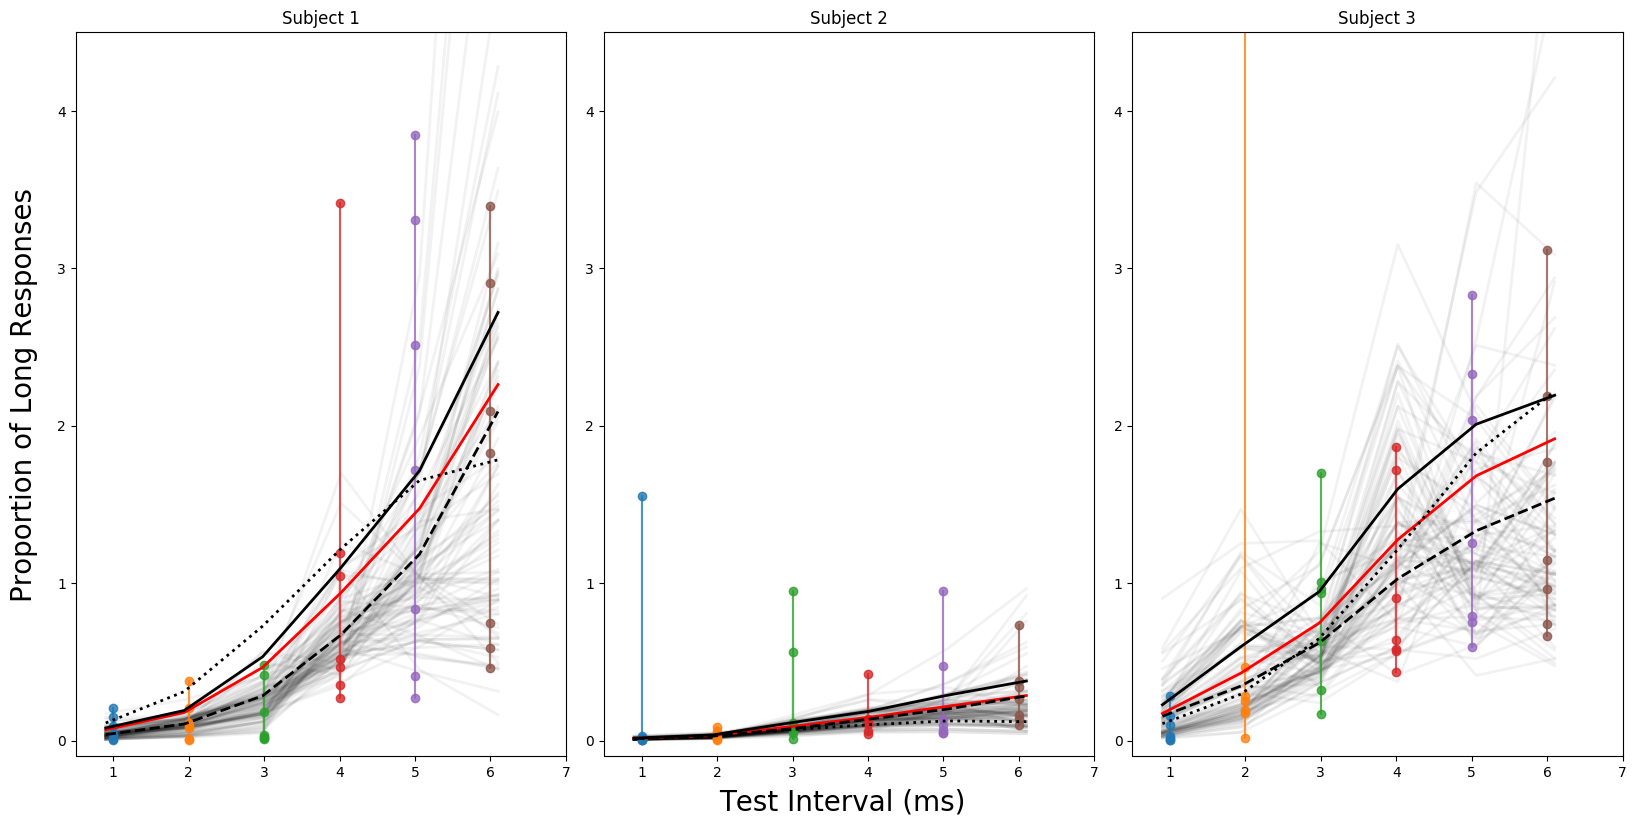

In [40]:
ppcsamples = 500
ppcsize = 100
# ppc = defaultdict(list)
burnin = 2000
fig = plt.figure(figsize=(16, 8))
fig.text(0.5, -0.02, 'Test Interval (ms)', ha='center', fontsize=20)
fig.text(-0.02, 0.5, 'Proportion of Long Responses', va='center', rotation='vertical', fontsize=20)
gs = gridspec.GridSpec(1, 3)
ppcsamples = 100

for ip in np.arange(companiesABC):
    ax = plt.subplot(gs[ip])
    xp = elec_year2[ip*7:(ip+1)*7, :]
    yp = elec_faults2[ip*7:(ip+1)*7, :]
    

    xl = np.linspace(0.9, 6.1, 6)
    
    y2 = Beta_Mu_2b[ip*5:(ip+1)*5, :]
    y2 = y2.mean(axis=0)

    y3 = Beta_Mu_3b[ip*5:(ip+1)*5, :]
    y3 = y3.mean(axis=0)
    
    y4 = Beta_Mu_4b[ip*5:(ip+1)*5, :]
    y4 = y4.mean(axis=0)
    
    y5 = Mean_output[ip]
    # Posterior sample from the trace
    for ips in np.random.randint(burnin, 3000, ppcsamples):
        param = trace_3b[ips]
        yl2 = np.exp(param['u']*(np.sqrt(param['beta1'][ip]*param['beta1'][ip] + param['beta4'][ip]**2)) + param['beta'] + (param['beta1'][ip] * (xl) + \
                     param['beta2'][ip]*elec_Pca_char1[ip*42:(ip*42+6)] + \
                     param['beta3'][ip]*elec_Pca_char2[ip*42:(ip*42+6)] + \
                      + param['beta4'][ip] *xl*xl)
                    )
        ax.plot(xl, yl2, 'k', linewidth=2, alpha=.05)
    
#     ax = sns.violinplot(data=elec_faults2[ip*7:(ip+1)*7])
    ax.plot(xp, yp, marker='o', alpha=.8)
    plt.plot(xl, y5, 'r', linewidth=2)
    plt.plot(xl, y2,  'k-', linewidth=2)
    plt.plot(xl, y3,  'k--', linewidth=2)
    plt.plot(xl, y4,  'k:', linewidth=2)
    plt.axis([0.5, 7, -.1, 4.5])
    plt.title('Subject %s' % (ip + 1))
    
plt.tight_layout()
plt.show()

In [41]:
# 训练误差
RmseTrain_all = RMSE(elec_faults, Mean_output, Len_One=6, Zoom_factor=100)
print(RmseTrain_all)

Rmse Mean is A、B、C :
{0: 0.008027283159397635, 1: 0.01030144492713528, 2: 0.008128019573464013}


In [42]:
# 预测误差
# 提取出第7年的预测值
Pred7year_M2 = M2_Pred_yplot_Mean_C[:,-1] #提取出ABC各省的均值预测值
Pred7year_M3 = M3_Pred_yplot_Mean_C[:,-1]
Pred7year_M4 = M4_Pred_yplot_Mean_C[:,-1]
Pred7year_M234 = np.vstack((Pred7year_M2, Pred7year_M3, Pred7year_M4)).T #输出为每个模型第7年的预测输出均值，第一行为A省，第2行为B省。。
# print(Pred7year_M234)
Pred7year_M234_Mean = Pred7year_M234.mean(axis=1) #按照行进行平均
print(Pred7year_M234_Mean)   #输出ABC三省第7年的预测值

Pred_Data = pd.read_csv('XZmulti_6_Only7Test.csv')
Pred_faults = 100 * (Pred_Data.Fault.values / Pred_Data.Nums.values)  # 数组形式,计算故障率大小
# print(Pred_faults)

# def Rmse(predictions, targets):
#     return np.sqrt(np.mean((predictions - targets) ** 2))

# def RMSEfor_Pred(Faults, FitValue, Len_One=7, Zoom_factor=100):
#     Len_Faults = np.shape(Faults)
#     Len_Fault = round(Len_Faults[0] / Len_One)  # round取整数，Len_Fault = 21/7 = 3

#     Faults = Faults / Zoom_factor  # 还原数据
#     FitValue = np.array(FitValue)
#     FitValue = FitValue / Zoom_factor  # 还原数据

#     Faults_Col = np.array([Faults[i * Len_One:(i + 1) * Len_One] for i in np.arange(Len_Fault)])  # 将输入数据排列好

#     Mean_Rmse = {}
#     for i in np.arange(3):
#         A = Rmse(Faults_Col[i], FitValue[i])  # 计算每组的均方根误差
#         # print(Rmse_Value)
#         Mean_Rmse[i] = A   # 计算每省的均方根误差
#     # print(Mean_Rmse)
#     print('Rmse Mean is A、B、C :')
#     return Mean_Rmse


RmseTrain_all = RMSEfor_Pred(Pred_faults, Pred7year_M234_Mean)
print(RmseTrain_all)

[4. 1. 2.]
Rmse Mean is A、B、C :
{0: 0.01842468256865871, 1: 0.003072425246058565, 2: 0.007926911227308238}


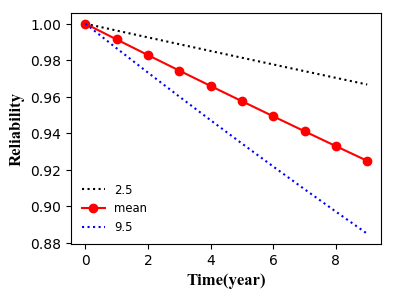

In [43]:
# 可靠度计算，beta_mu要除以100还原
post_alpha1 = np.mean(chain_2b['alpha'])
post_beta_mu1 = np.mean(chain_2b['beta_mu'])/100

varnames1 = ['alpha', 'beta_mu']
aaa1 = pm.df_summary(trace_2b, varnames1)
bbb1 = pd.DataFrame(aaa1)

hpdd2_5 = bbb1['hpd_2.5']
hpdd97_5 = bbb1['hpd_97.5']
hpd2_5_alpha = hpdd2_5[:1].mean()
hpd97_5_alpha = hpdd97_5[:1].mean()
hpd25_beta_mu = hpdd2_5[1:].mean()/100
hpd975_beta_mu = hpdd97_5[1:].mean()/100




# 可靠度函数：这里为故障度函数
fig = plt.figure(figsize=(4, 3))
ax = plt.subplot(1, 1, 1)
t = np.arange(0, 10, 1)
R1 = np.exp(-((t/post_beta_mu1)**post_alpha1))
R2 = np.exp(-((t/hpd25_beta_mu)**hpd2_5_alpha))
R3 = np.exp(-((t/hpd975_beta_mu)**hpd97_5_alpha))
# plt.plot(t, R2, 'k:', t, R1, 'bo-', t, R3, 'r:')
# 需要进行转换以进行可靠度分析，依据书71页的表达式，可反推出可靠度函数
R11 = np.exp(-((t/post_alpha1)*post_beta_mu1))
R22 = np.exp(-((t/hpd2_5_alpha)*hpd25_beta_mu))
R33 = np.exp(-((t/hpd97_5_alpha)*hpd975_beta_mu))
plt.plot(t, R22, 'k:', t, R11, 'ro-', t, R33, 'b:')
# ax.set_xticklabels(['2016', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'], fontsize='small')
ax.set_xlabel("Time(year)", fontdict=font1)
plt.ylabel("Reliability", fontdict=font1)
# plt.legend([Company_names[0]], loc='upper left', frameon=False, fontsize='small')
ax.legend(['2.5','mean','9.5'], loc='lower left',frameon=False, fontsize='small')

plt.savefig('E:\\Code\\Bayescode\\QW_reliable\\SCI\\New12\\Picture\\Reliability.png', dpi = 200, bbox_inches='tight')
plt.show()